# Universe Machine

# Notes


TODO:
* Once things are restructured get this ready for PR
* https://docs.google.com/document/d/1kRZUw_nHksmnfgu_u6OtERTrl_w-xgio5t7WndmFQPA/edit
* https://redwoodforest.slack.com/archives/D6UA26L6R/p1515102490000636
* Decide how to drop data in the heatmaps
* Sanity check that halo scatter matches stellar scatter (based off the slope): https://redwoodforest.slack.com/archives/C8G02V8F9/p1516236118000202

New TODO:

# Preamble, Imports, Plotting config

In [19]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
np.set_printoptions(linewidth=1000)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import astropy.io.fits
import time
import pandas as pd

# My libs
import data
import plots as p
import smhm_fit
import fits
import halo_info


# when we mess up imports
from importlib import reload

In [21]:
mpl.rcParams.update({'figure.dpi': 200})
def fig_font_size(size = 12):
    mpl.rcParams.update({'font.size': size})
fig_font_size()

# Data

In [6]:
# Note that we have already cut (as of 1 Feb) to centrals with mp > 12
# https://github.com/dr-guangtou/hsc_um2/blob/master/scripts/reduce_um_data_size.py
centrals, satellites = data.load()
print(np.log10(np.min(centrals["mp"])))
print(len(centrals))

11.50023647482564
1076948


### Vis raw data

In [ ]:
d = data_stellar_cut["cen"]["data"]
hm_phm_ratio = d["m"] / d["mp"]

fig, ax = plt.subplots()
ax.hist(hm_phm_ratio, bins=50)
ax.set(
    yscale="log",
    ylabel="Count",
    xlabel="HM / Peak HM",
)

In [ ]:
d.dtype

In [ ]:
d  = data_stellar_cut["cen"]["data"], data_stellar_cut["halo"]["data"]
dh = data_stellar_cut["halo"]["data"]["id" == d["id"]]
sm_hm_ratio = (d["sm"] + d["icl"]) / d["m"]
cen_sm_perc = (d["sm"] + d["icl"]) / (dh["sm"] + dh["icl"])

plt.histogram(sm_hm_ratio, cen_sm_perc, bins=50)

In [ ]:
d = data_stellar_cut["cen"]["data"]
sm_hm_ratio = (d["sm"] + d["icl"]) / d["m"]
fig, ax = plt.subplots()
ax.hist(sm_hm_ratio, bins=50)
ax.set(
    ylabel="Count",
    xlabel="SM / HM",
)
ax.axvline(0.2, color="r")

In [ ]:
hm = np.log10(centrals["m"])
sm = np.log10(centrals["sm"] + centrals["icl"])
hist, x_edge, y_edge = np.histogram2d(hm, sm, bins=50)

hist = np.log10(hist)
hist = hist.T

fig, ax = plt.subplots()
img = ax.imshow(hist, origin="lower", extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], aspect="auto")
fig.colorbar(img)
ax.set(
    xlabel="HM",
    ylabel="SM",
)
ax.axhline(11.2)
ax.axvline(13)
#ax.axhline(12, c="r")
#ax.axvline(14.5, c="r")

## Process data

In [8]:
data_stellar_cut = data.sm_cuts_with_sats(centrals, satellites, smhm_fit.get_hm_at_fixed_sm_fit)
data_halo_cut = data.hm_cuts_with_sats(centrals, satellites, smhm_fit.get_sm_at_fixed_hm_fit)

[5.3703179637025325e+19, 1.0964781961431828e+18, 10, 10, 20]
[5.3703179637025325e+19, 1.0964781961431828e+18, 10, 10, 20]
[5.3703179637025325e+19, 1.0964781961431828e+18, 10, 10, 20]
[5.3703179637025325e+19, 1.0964781961431828e+18, 10, 10, 20]
[5.3703179637025325e+19, 1.0964781961431828e+18, 10, 10, 20]
[5.3703179637025325e+19, 1.0964781961431828e+18, 10, 10, 20]
[5.3703179637025325e+19, 1.0964781961431828e+18, 10, 10, 20]
[5.3703179637025325e+19, 1.0964781961431828e+18, 10, 10, 20]
[5.3703179637025325e+19, 1.0964781961431828e+18, 10, 10, 20]
[5.3703179637025325e+19, 1.0964781961431828e+18, 10, 10, 20]
[5.3703179637025325e+19, 1.0964781961431828e+18, 10, 1e-09, 1e-09]
[5.3703179637025325e+19, 1.0964781961431828e+18, 10, 10, 20]


/home/christopher/research/hsc_um2/cb/smhm_fit.py:83: RuntimeWarning: overflow encountered in power
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))
/home/christopher/research/hsc_um2/cb/smhm_fit.py:83: RuntimeWarning: overflow encountered in multiply
  ((gamma * np.power(usm, delta - gamma - 1)) / (sm0 * np.power(denom, 2))))


In [9]:
for key in data_stellar_cut.keys():
    print(key, len(data_stellar_cut[key]["data"]), len(data_halo_cut[key]["data"]))

cen 37477 36491
1 39061 36491
2 30094 36491
5 33983 36491
halo 34869 36491
insitu 33309 36490


In [10]:
for key in data_stellar_cut.keys():
    mass, csmf = fits.build_csmf(data_stellar_cut, key)
    data_stellar_cut[key]["smf"] = (mass, csmf) # note that these masses are log!
    if key is not "insitu":
        data_stellar_cut[key]["rmf"] = fits.build_rmf(data_stellar_cut[key]["richness"])

for key in data_halo_cut.keys():
    mass, csmf = fits.build_csmf(data_halo_cut, key)
    data_halo_cut[key]["smf"] = (mass, csmf) # note that these masses are log!
    if key is not "insitu":
        data_halo_cut[key]["rmf"] = fits.build_rmf(data_halo_cut[key]["richness"])

data_stellar_cut["cen"]["hmf"] = fits.build_chmf(data_stellar_cut, "cen")

In [11]:
print(data_halo_cut.keys())
print(data_halo_cut["cen"].keys())
print(data_stellar_cut["cen"].keys())

dict_keys(['cen', 1, 2, 5, 'halo', 'insitu'])
dict_keys(['data', 'fit', 'richness', 'smf', 'rmf'])
dict_keys(['data', 'fit', 'richness', 'smf', 'rmf', 'hmf'])


### Sanity check these fits

They all kinda look like power laws? A little too much like power laws.

Also some analysis of these fits in the paper

If we are going for a power law, we have
```
log(HM) = log(M1) + B log(SM / sm0)
HM = M1 * (SM/sm0)^B = M1 * SM^B / (sm0)^B = M1/sm0^B * SM^B
log(HM) = log(M1/sm0*B) + B*log(SM)
log(HM) = log(M1)-log(sm0) - log(B) + B*SM
```

In [ ]:
print("m1, sm0, beta, delta, gamma")
for key in data_halo_cut.keys():
    f = data_halo_cut[key]["fit"]
    print("{}, {:2f}, {:2f}, {:2f}, {:2f}, {:2f}".format(key, np.log10(f[0]), np.log10(f[1]), f[2], f[3], f[4]))

In [ ]:
def get_power_law_coeffs(m1, sm0, beta, delta, gamma):
    if np.abs(gamma) > 1e-9 or np.abs(delta) > 1e-9:
        print("not a power law!")
        return
    # y = az^(b)
    a = np.log10(m1) - np.log10(sm0) - np.log10(beta)
    b = beta
    print("HM = {} * SM ^ {}".format(a, b))
    print("SM = {} * HM ^ {}".format(1/(a**(1/b)), 1/b))
for key in data_halo_cut.keys():
    print(key)
    get_power_law_coeffs(*data_halo_cut[key]["fit"])
for key in data_stellar_cut.keys():
    print(key)
    get_power_law_coeffs(*data_stellar_cut[key]["fit"])

In [ ]:
for key in data_halo_cut.keys():
    print(data_halo_cut[key]["fit"])

#### Plots

In [ ]:
for key in ["cen"]: #data_stellar_cut.keys():
    p.sm_hm.dm_vs_sm(data_stellar_cut[key]["data"], key, fit=data_stellar_cut[key]["fit"])

In [ ]:
for key in ["cen"]:#data_halo_cut.keys():
    p.sm_hm.sm_at_fixed_hm(data_halo_cut[key]["data"], key, fit=data_halo_cut[key]["fit"])

# Intro Plot

Intro everything by showing the SM-HM plot + some of the scatter plots (including lit values)

In [ ]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(7, 4)
p.sm_hm.sm_vs_dm(data_halo_cut["halo"]["data"], "halo", fit=data_halo_cut["halo"]["fit"], ax=axes[0])
p.scatter.in_sm_at_fixed_hm_incl_lit(data_halo_cut, ax=axes[1])
plt.tight_layout()

# Scatter for various definitions of stellar mass

In [ ]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(7, 4)
p.scatter.in_sm_at_fixed_hm(data_halo_cut, ax=axes[0])
p.scatter.in_hm_at_fixed_number_density(data_stellar_cut, ax=axes[1])
plt.tight_layout()
axes[0].set_ylim(axes[1].get_ylim())

# Stellar mass function for various SMs and vs HSC etc


In [ ]:
fits.density_at_mass(data_stellar_cut, "cen", fits.mass_at_density(data_stellar_cut, "cen", 1e2))

In [ ]:
_, ax = plt.subplots()
for key in data_stellar_cut.keys():
    smf_data = data_stellar_cut[key]["smf"]
    ax.plot(smf_data[0], smf_data[1], label=key)
ax.set_yscale("log")
ax.legend()

In [ ]:
_, ax = plt.subplots()
for key in data_stellar_cut.keys():
    smf_data = data_stellar_cut[key]["smf"]
    ax.plot(smf_data[0], smf_data[1], label=key)
ax.set_yscale("log")
ax.legend()

### Comparison with HSC etc

In [ ]:
hsc_smf_file_m10 = "/home/christopher/research/hsc_um2/data/s16a_massive_fastlane_logm10_smf_default.fits"
hsc_smf_file_m100 = "/home/christopher/research/hsc_um2/data/s16a_massive_fastlane_logm100_smf_default.fits"

m10_smf = astropy.io.fits.open(hsc_smf_file_m10)[1].data
m100_smf = astropy.io.fits.open(hsc_smf_file_m100)[1].data

In [ ]:
print(m10_smf.dtype)
print(m10_smf)

In [ ]:
def plot_sim_smf(stellar_masses, ax, label):

    nonzero_stellar_masses = np.log10(stellar_masses[stellar_masses != 0])
    print("Dropped {} galaxies with mass of 0".format(len(stellar_masses) - len(nonzero_stellar_masses)))

    sim_volume = 400**3 # https://redwoodforest.slack.com/archives/C5W6EQCAU/p1513187949000425 SMDPL
    num_bins = 30
    x, y, err = smf.compute_smf(
        nonzero_stellar_masses, sim_volume, num_bins, 
        np.min(nonzero_stellar_masses), np.max(nonzero_stellar_masses),
    )
    ax.errorbar(x, y, yerr = err, label=label)


fig, ax = plt.subplots()
ax.errorbar(m10_smf["logm_mean"], m10_smf["smf"], yerr = m10_smf["smf_err"], label="HSC m10")
ax.errorbar(m100_smf["logm_mean"], m100_smf["smf"], yerr = m100_smf["smf_err"], label="HSC m100")
plot_sim_smf(centrals["sm"], ax, "universe machine insitu centrals")
plot_sim_smf(centrals["sm"] + centrals["icl"], ax, "all mass cents")
plot_sim_smf(np.append(centrals["sm"] + centrals["icl"], satellites["sm"] + satellites["icl"]), ax, "all mass cents and sats")
ax.legend()
ax.set(
    yscale="log",
    xlim=[11, 12.4],
)
fig.set_size_inches(18.5, 10.5)

# Richness as an estimator

What about richness? Does that have a relation with scatter at fixed halo mass

## Sanity check RMF

In [ ]:
fits.density_at_richness(data_stellar_cut, "cen", fits.richness_at_density(data_stellar_cut, "cen", 2e-4))

In [ ]:
#p.scatter.in_richness_at_fixed_hm(data_halo_cut)
#p.scatter.in_hm_at_fixed_richness_number_density(data_stellar_cut)

_, ax = plt.subplots()
rmf_data = data_stellar_cut["cen"]["rmf"]
ax.plot(rmf_data[0], rmf_data[1], label="stellar cut")
rmf_data = data_halo_cut["cen"]["rmf"]
ax.plot(rmf_data[0], rmf_data[1], label="halo cut")
ax.set_yscale("log")
ax.legend()

## Richness plots


In [ ]:
r = data_stellar_cut["cen"]["richness"]

ex = r[r["richness"] == 2]
#plt.hist(r, bins=int(np.max(r["richness"])))
#plt.yscale("log")
plt.hist(np.log10(ex["m"])

In [ ]:
ax = p.scatter.in_hm_at_fixed_richness_number_density(data_stellar_cut)

### Old color plots

In [ ]:
# Only count sats of a large enough size towards richness
minMassForRichness = 10**10.8
richness = cluster_sum.get_richness(centrals_halo_cut, satellites, minMassForRichness)
print("Out of {} clusters, {} have a richness > 0".format(len(richness), np.count_nonzero(richness)))
heatmaps.richness_and_hm_vs_sm_scatter(
    data_halo_cut[0]["data"],
    satellites,
    minMassForRichness,
    data_halo_cut[0]["fit"],
    0,
)

In [ ]:
heatmaps.richness_and_sm_vs_hm_scatter(
    data_stellar_cut[0]["data"],
    satellites,
    minMassForRichness,
    data_stellar_cut[0]["fit"],
    0,
)

# Is cen scatter correlated with halo scatter?

In [ ]:
cens_bias = halo_info.get_sm_bias(data_halo_cut["cen"], include_id=True)
halos_bias = halo_info.get_sm_bias(data_halo_cut["halo"], include_id=True)

In [ ]:
cen_bias = pd.DataFrame({"cen_bias": cens_bias["sm_bias"]}, index=cens_bias["id"])
halo_bias = pd.DataFrame({"halo_bias": halos_bias["sm_bias"]}, index=halos_bias["id"])

In [ ]:
print(cen_bias.head())
print(halo_bias.head())

In [ ]:
joined = cen_bias.join(halo_bias, how="inner")

In [ ]:
fig, ax = plt.subplots()
_, _, _, img = ax.hist2d(joined["cen_bias"], joined["halo_bias"], cmap="OrRd", norm=mpl.colors.LogNorm(), bins=30)
ax.set(xlabel=r"$M_{\ast, cen}\ scatter$", ylabel=r"$M_{\ast, halo}\ scatter$")
plt.colorbar(img, label="count")

# What could cause the scatter in the SMHR?

## Lasso to find the best linear model

In [ ]:
weights, intercept = p.physical_correlation_plots.lasso(data_halo_cut["cen"])
print(weights, intercept)

In [ ]:
p.physical_correlation_plots.lasso(data_halo_cut["halo"])

## Correlation plots

In [ ]:
p.physical_correlation_plots.correlation_matrix(data_halo_cut["cen"])
p.physical_correlation_plots.correlation_matrix(data_halo_cut["halo"])
p.physical_correlation_plots.cen_vs_halo_correlation_matrix(data_halo_cut["cen"], data_halo_cut["halo"])
p.physical_correlation_plots.marginalized_heatmap(data_halo_cut["cen"])

## Use best model to predict SM bias

In [ ]:
p.physical_correlation_plots.margin_model(data_halo_cut["cen"])

In [ ]:
p.physical_correlation_plots.margin_model(data_halo_cut["halo"])

In [ ]:
p.physical_correlation_plots.best_model(data_halo_cut["cen"])

# Concentration - is that correlated with over/undermassive halos

Same as richness but for concentration

In [ ]:
p.physical_correlation_plots.sm_at_fixed_hm_conc_split(data_halo_cut["halo"])

In [ ]:
p.physical_correlation_plots.conc_sm_heatmap_at_fixed_hm(data_halo_cut["cen"])

# Age

What about age?

In [ ]:
p.physical_correlation_plots.sm_at_fixed_hm_age_split(data_halo_cut["halo"])

# Major Mergers

In [ ]:
p.physical_correlation_plots.sm_at_fixed_hm_mm_split(data_halo_cut["cen"])

# Comparison of secondary feature distribution

Let's look at how a selection on stellar mass could bias the secondary features.
1. Select a sample by cutting on some variant of SM
2. Select a sample by matching the halo mass distribution of 1
3. Compare features of 1 and 2

## Concentration

central cuts of (11.9, 12.1), halo cuts of (12.37613979718486, 12.627555941515935)
SM sample size: 500	SM median halo mass: 1.67e+14	SM std halo mass: 1.16e+14
SM sample size: 509	SM median halo mass: 2.12e+14	SM std halo mass: 5.41e+13


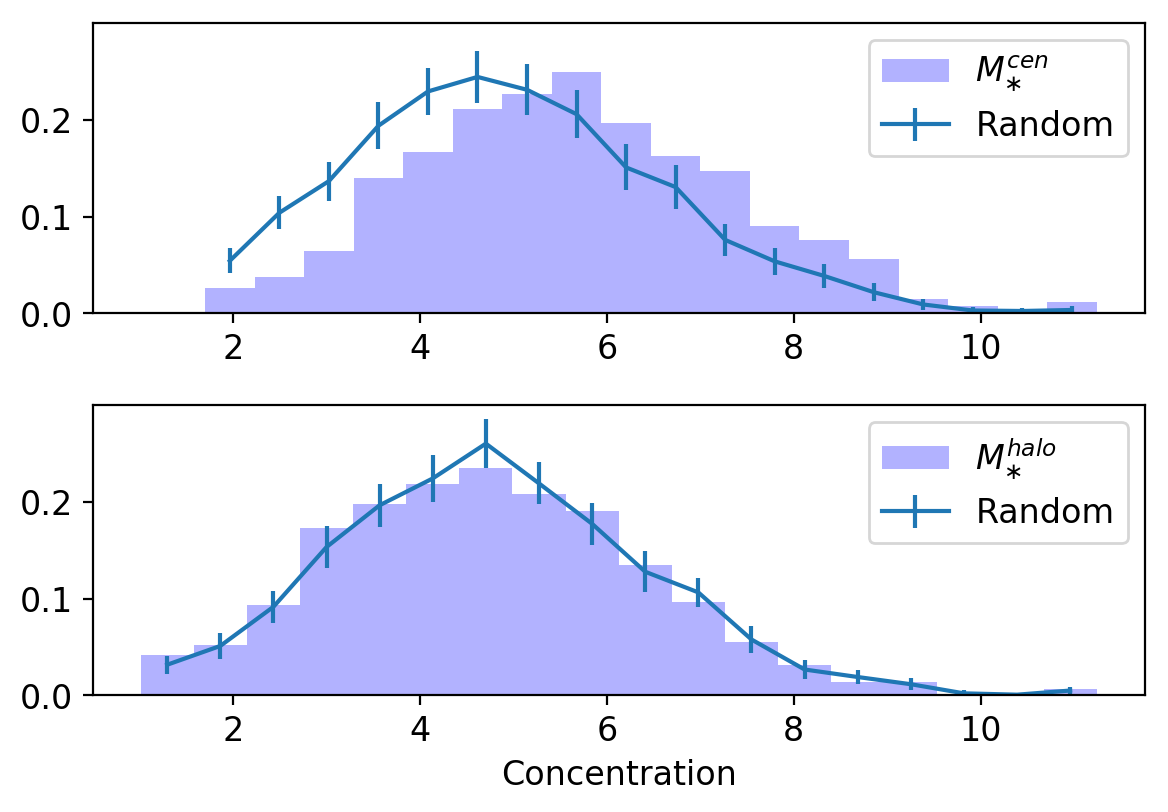

In [209]:
cen_cuts = (11.9, 12.1)
halo_cuts = tuple(fits.mass_at_density(data_halo_cut, "halo", fits.density_at_mass(
        data_halo_cut, "cen", m)) for m in cen_cuts)
print("central cuts of {}, halo cuts of {}".format(cen_cuts, halo_cuts))

_, axes = plt.subplots(2, 1)
p.same_hm_dist_plots.plot_pdf(data_halo_cut, "cen", p.same_hm_dist_plots.f_concentration, cuts=cen_cuts, ax=axes[0], bins=18)
p.same_hm_dist_plots.plot_pdf(data_halo_cut, "halo", p.same_hm_dist_plots.f_concentration, cuts=halo_cuts, ax=axes[1], bins=18)
plt.tight_layout()
axes[1].set(**{"xlabel": "Concentration"})
for ax in [axes[0], axes[1]]:
    ax.set(**{"xlim": (min(axes[0].get_xlim()[0], axes[1].get_xlim()[0]), max(axes[0].get_xlim()[1], axes[1].get_xlim()[1])), 
              "ylim": (0, max(axes[0].get_ylim()[1], axes[1].get_ylim()[1]))})

SM sample size: 509	SM median halo mass: 2.12e+14	SM std halo mass: 5.41e+13
Ks_2sampResult(statistic=0.031434184675834975, pvalue=0.9603450095109024)


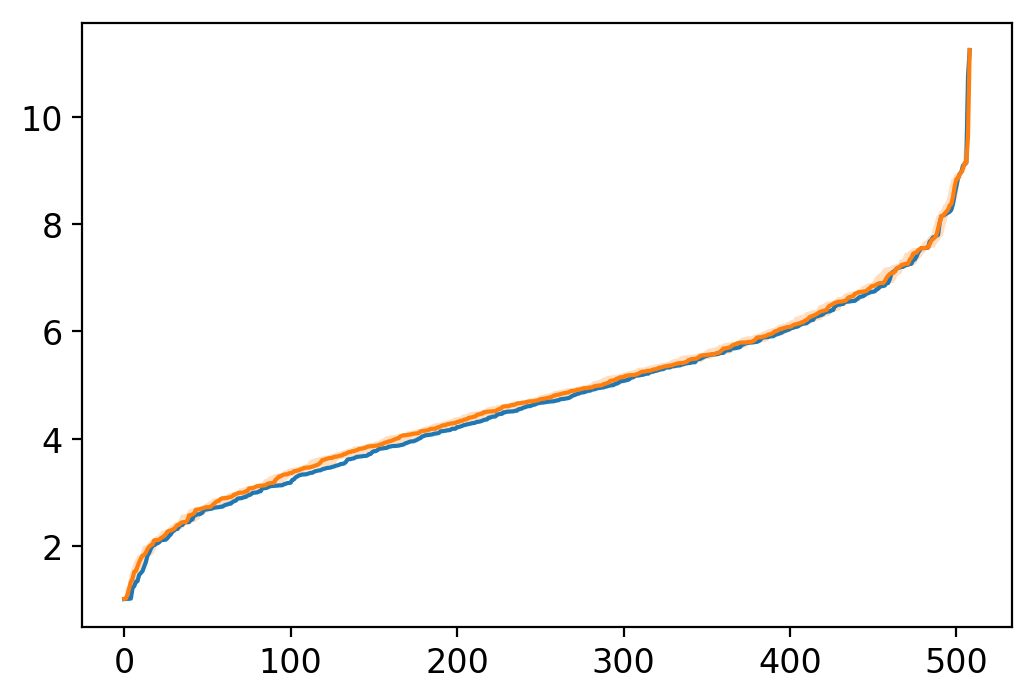

In [210]:
p.same_hm_dist_plots.plot_cdf(data_halo_cut, "halo", p.same_hm_dist_plots.f_concentration, cuts=halo_cuts)

In [ ]:
res = []
keys = ['cen', 1, 2, 5, 'halo']
labels = ["Concentration", "Age", "MM"]
cuts = [(11.9, 12.1), (11.6, 11.7)]

for cut in cuts:
    res.append([])
    for f in [p.same_hm_dist_plots.f_concentration, p.same_hm_dist_plots.f_age, p.same_hm_dist_plots.f_mm]:
        res[-1].append([])
        for k in keys:
            c = tuple(fits.mass_at_density(data_halo_cut, k, fits.density_at_mass(
                data_halo_cut, "cen", m)) for m in cut)
            res[-1][-1].append(p.same_hm_dist_plots.ks_test(data_halo_cut, k, f, cuts=c))

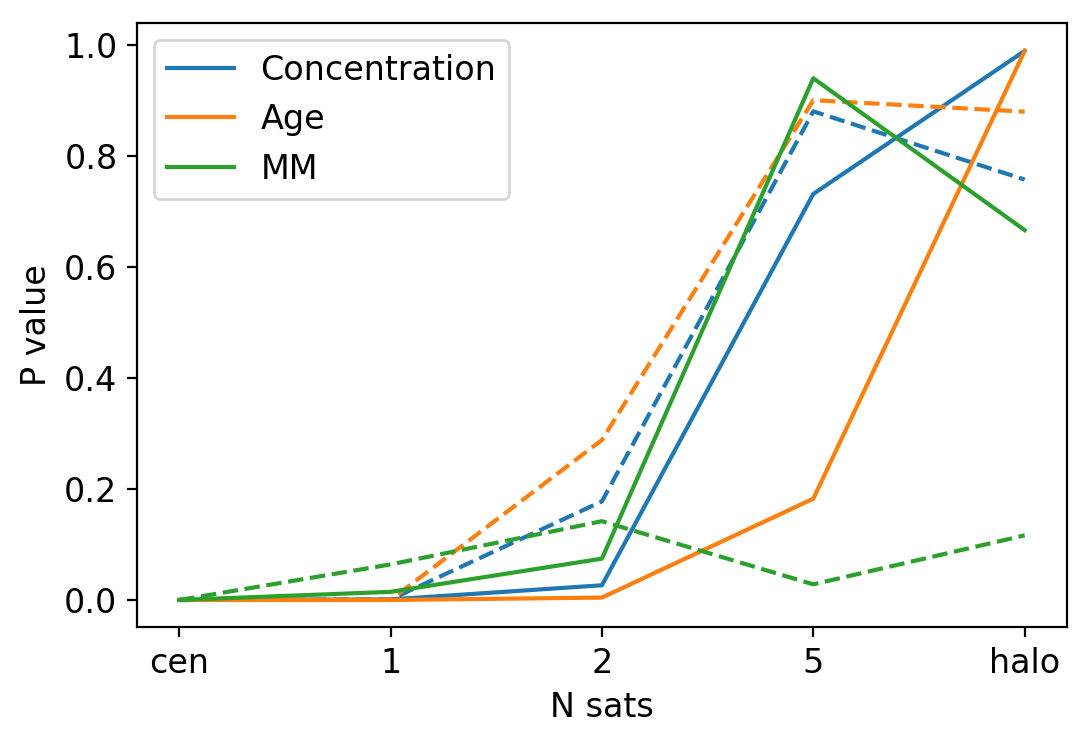

In [247]:
_, ax = plt.subplots()

for i in range(len(res[0])):
    l = ax.plot(res[0][i], label=labels[i])
    ax.plot(res[1][i], ls="dashed", color=l[0].get_color())

ax.set(
    xticks=ax.get_xticks()[1::2],
    xticklabels=keys,
    ylabel="P value",
    xlabel="N sats",
)
ax.legend()

## Age

SM sample size: 500	SM median halo mass: 1.67e+14	SM std halo mass: 1.16e+14
SM sample size: 509	SM median halo mass: 2.12e+14	SM std halo mass: 5.41e+13


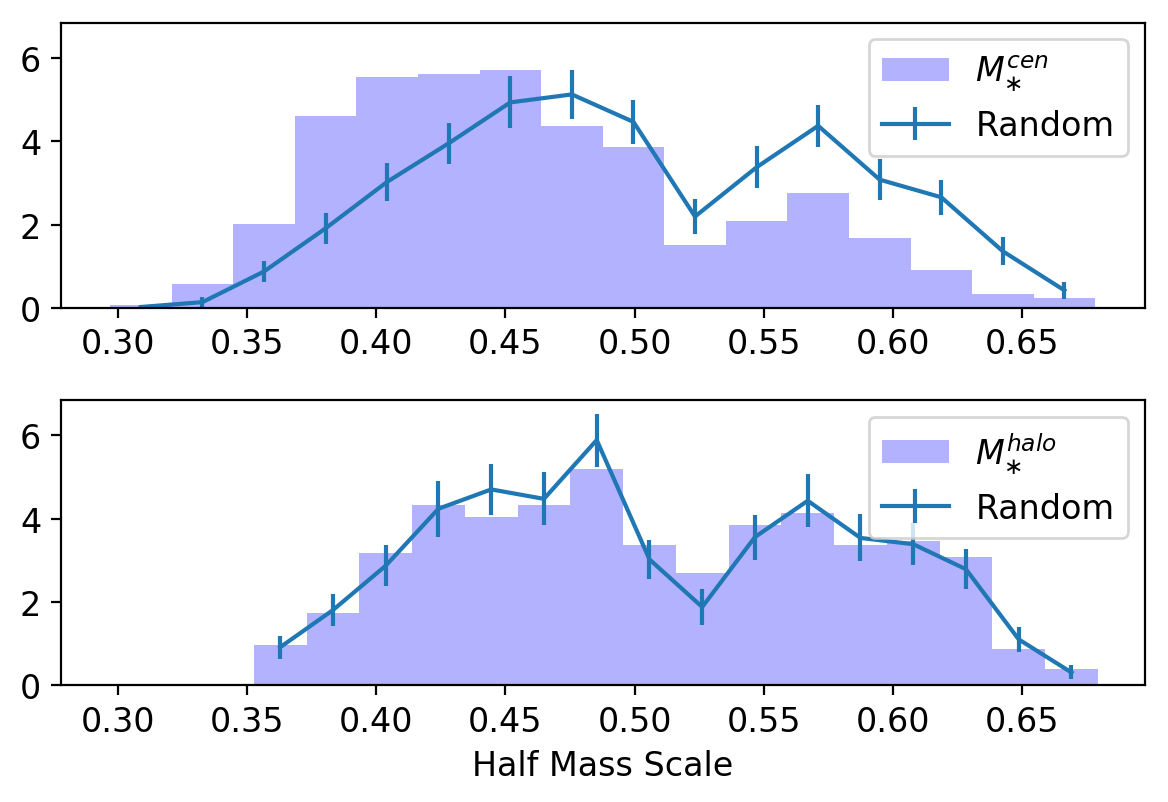

In [216]:
# Remember that the way we are binning this is a bit subtle
_, axes = plt.subplots(2, 1)
p.same_hm_dist_plots.plot_pdf(data_halo_cut, "cen", p.same_hm_dist_plots.f_age, cuts=cen_cuts, ax=axes[0], bins=16)
p.same_hm_dist_plots.plot_pdf(data_halo_cut, "halo", p.same_hm_dist_plots.f_age, cuts=halo_cuts, ax=axes[1], bins=16)
plt.tight_layout()
axes[1].set(**{"xlabel": "Half Mass Scale"})
for ax in [axes[0], axes[1]]:
    ax.set(**{"xlim": (min(axes[0].get_xlim()[0], axes[1].get_xlim()[0]), max(axes[0].get_xlim()[1], axes[1].get_xlim()[1])), 
              "ylim": (0, max(axes[0].get_ylim()[1], axes[1].get_ylim()[1]))})

SM sample size: 509	SM median halo mass: 2.12e+14	SM std halo mass: 5.41e+13
Ks_2sampResult(statistic=0.03339882121807469, pvalue=0.935221521170702)


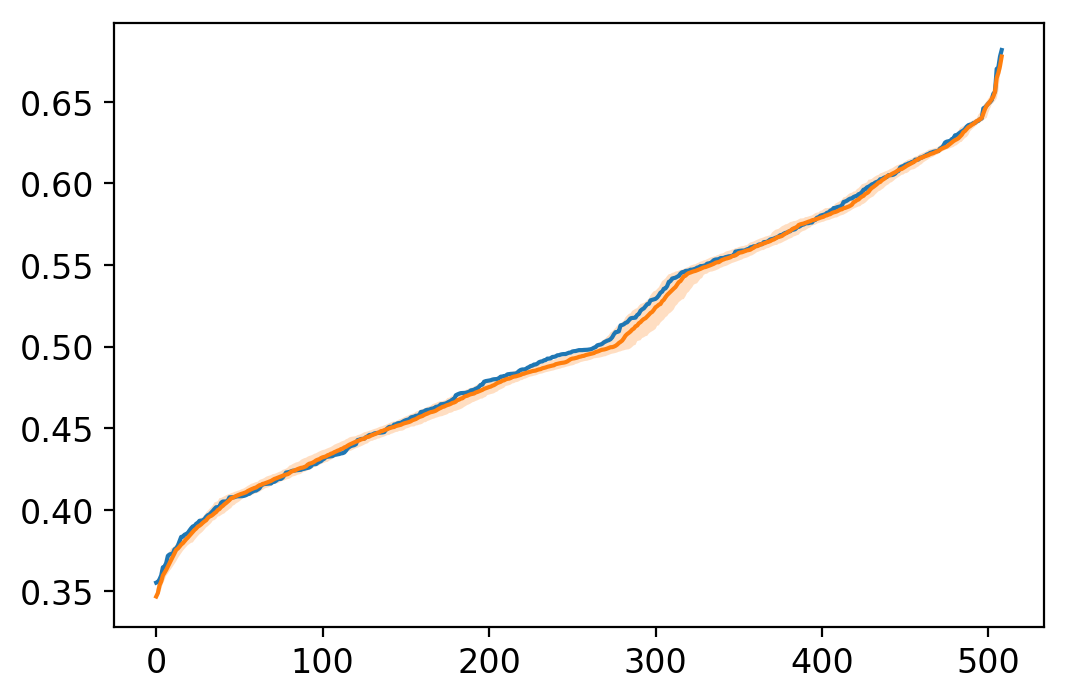

In [219]:
p.same_hm_dist_plots.plot_cdf(data_halo_cut, "halo", p.same_hm_dist_plots.f_age, cuts=halo_cuts)

## MM

SM sample size: 1739	SM median halo mass: 4.59e+13	SM std halo mass: 4.32e+13
SM sample size: 1788	SM median halo mass: 6.50e+13	SM std halo mass: 1.92e+13


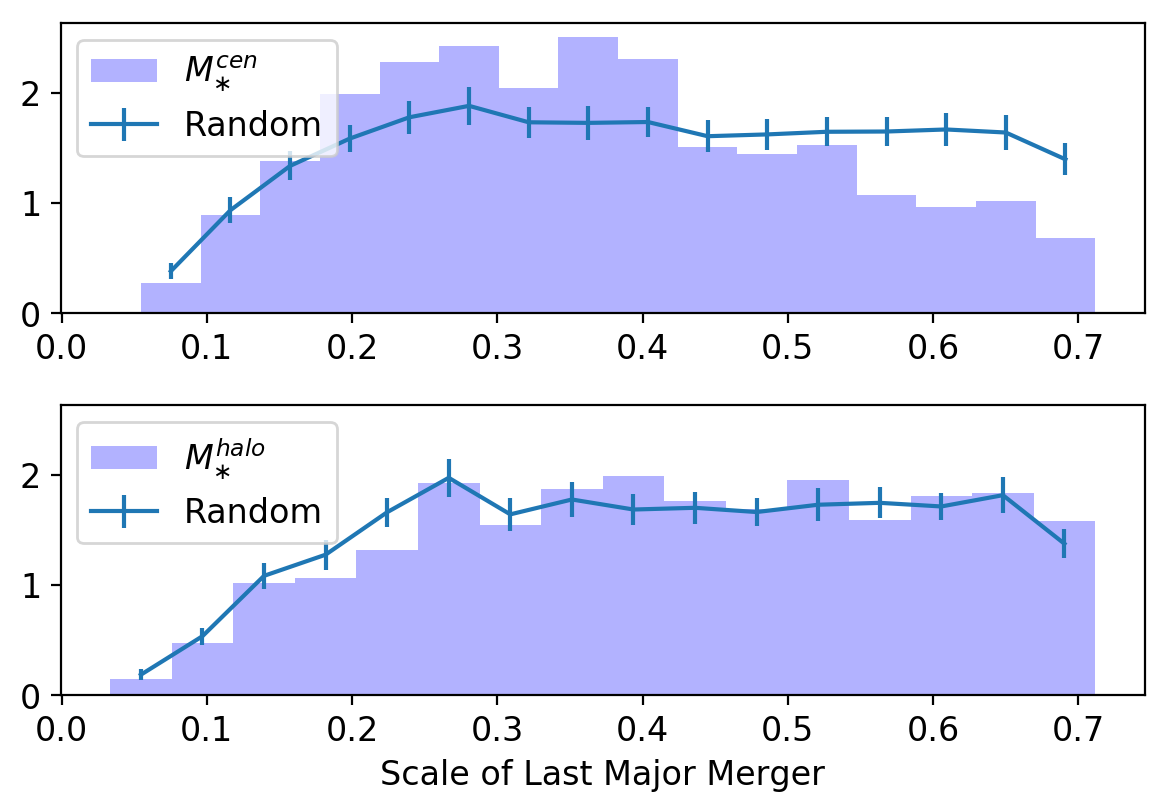

In [107]:
# Remember that the way we are binning this is a bit subtle
_, axes = plt.subplots(2, 1)
p.same_hm_dist_plots.plot_pdf(data_halo_cut, "cen", p.same_hm_dist_plots.f_mm, cuts=cen_cuts, ax=axes[0], bins=16)
p.same_hm_dist_plots.plot_pdf(data_halo_cut, "halo", p.same_hm_dist_plots.f_mm, cuts=halo_cuts, ax=axes[1], bins=16)
plt.tight_layout()
axes[1].set(**{"xlabel": "Scale of Last Major Merger"})
for ax in [axes[0], axes[1]]:
    ax.set(**{"xlim": (min(axes[0].get_xlim()[0], axes[1].get_xlim()[0]), max(axes[0].get_xlim()[1], axes[1].get_xlim()[1])), 
              "ylim": (0, max(axes[0].get_ylim()[1], axes[1].get_ylim()[1]))})

## Sanity check of how we bin discrete scales

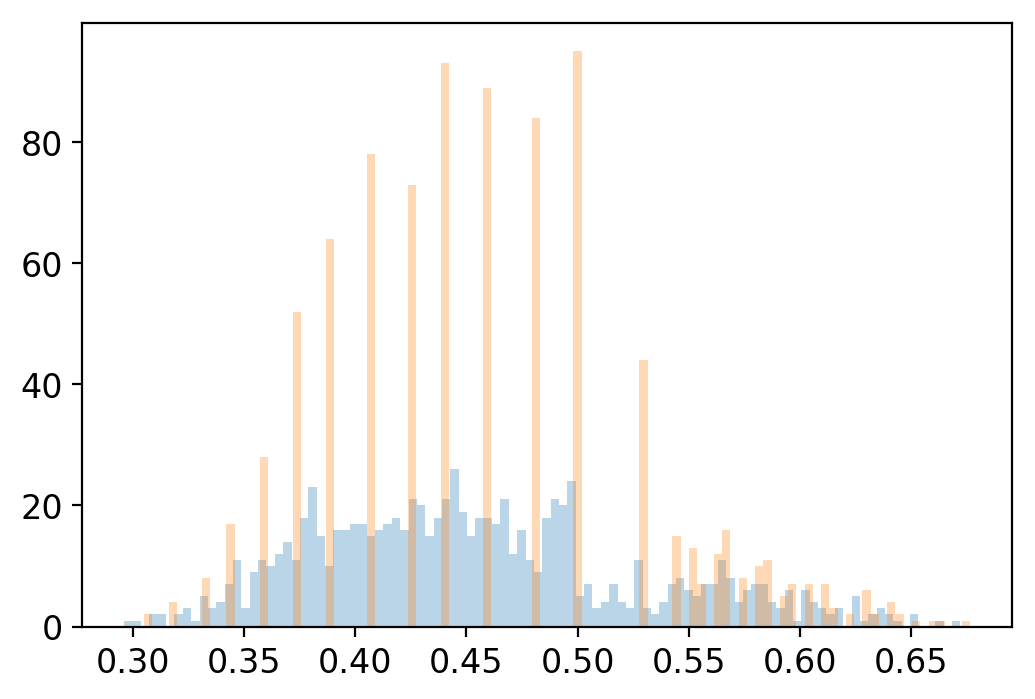

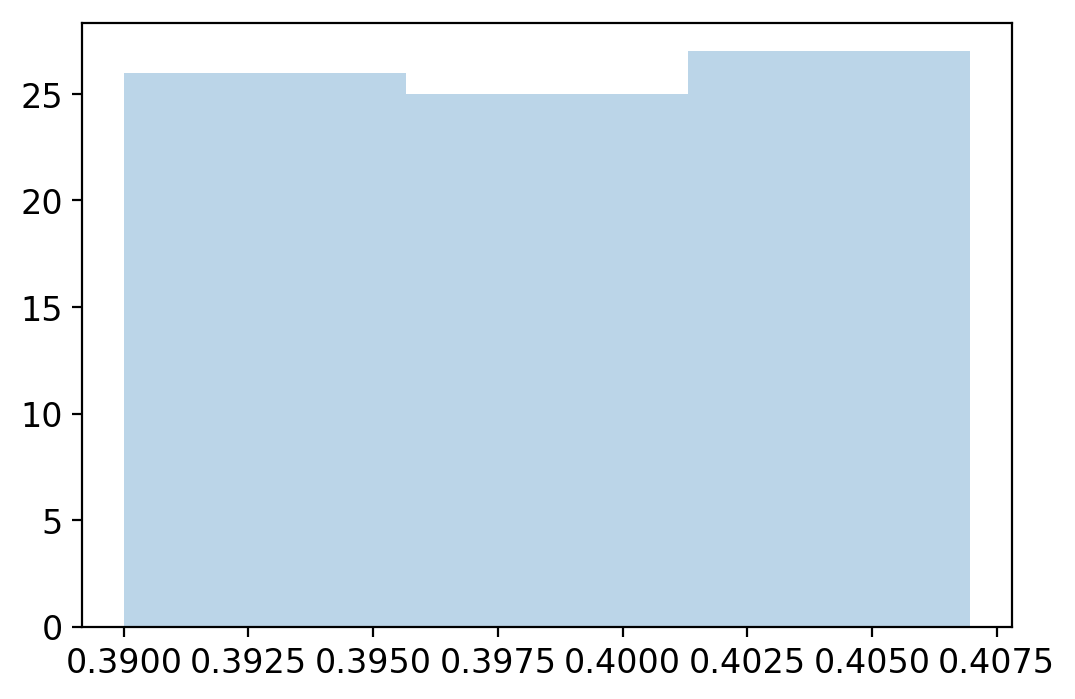

In [230]:
cuts = (11.8, 12)
catalog = data_halo_cut["cen"]["data"]
sm_sample = catalog[
    (catalog["sm"] + catalog["icl"] > 10**cuts[0]) & 
    (catalog["sm"] + catalog["icl"] < 10**cuts[1])   
]                   

p.same_hm_dist_plots.f_age(sm_sample, plot=True)
None